In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import openslide
from PIL import Image, ImageDraw

import time

import matplotlib as mpl
import matplotlib.pyplot as plt

import get_tile_of_wsi as gt

In [2]:
def get_points(xmlfile,color_map=None):
    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()        
    
    map_idx = []
    points = []

    for annotation in root.findall('Annotation'):        
        line_color = int(annotation.get('LineColor'))        
        mapped_idx = [item[1] for item in color_map if item[0] == line_color][0]        
                
        for regions in annotation.findall('Regions'):
            for annCount, region in enumerate(regions.findall('Region')):                
                #map_idx[annCount] = mapped_idx
                map_idx.append(mapped_idx)
                
                for vertices in region.findall('Vertices'):
                    points.append([None] * len(vertices.findall('Vertex')))                    
                    for k, vertex in enumerate(vertices.findall('Vertex')):
                        points[-1][k] = (int(float(vertex.get('X'))), int(float(vertex.get('Y'))))                                        

    return points, map_idx

In [ ]:
def mask_out_annotation(xml_fname,img_fname=None,desired_mpp=None):

    # first element is annotation LineColor property, second element is what to put in mask
    # colors are: Yellow,1 Green,2 Blue,3 Red,4 Purple,5
    color_map = [(65535,1),(65280,2),(16711680,3),(255,4),(16711808,4)]    
    points, map_idx = get_points(xml_fname,color_map=color_map)

    if img_fname is not None:
        osh_img = openslide.OpenSlide(img_fname)
        img_dim = osh_img.level_dimensions
        img_mpp = round(float(osh_img.properties['openslide.mpp-x']),2)
        resize_factor = img_mpp / desired_mpp                
    else:
        resize_factor = 1
    
    for k, pointSet in enumerate(points):
        points[k] = [(int(p[0] * resize_factor), int(p[1] * resize_factor)) for p in pointSet]
    
    img = Image.new('L', (int(img_dim[0][0] * resize_factor), int(img_dim[0][1] * resize_factor)), 0)

    for annCount, pointSet in enumerate(points):        
        ImageDraw.Draw(img).polygon(pointSet, fill=map_idx[annCount])

    mask = np.array(img)    

    return mask, resize_factor

In [ ]:
# coords is relative to the lowest-MPP layer, while wh is relative to desired_mpp
def mask_out_region(xml_fname,img_fname=None,desired_mpp=None,coords=(0,0),wh=(256, 256)):
    color_map = [(65535,1),(65280,2),(16711680,3),(255,4),(16711808,5)]    
    points, map_idx = get_points(xml_fname,color_map=color_map)
    
    if img_fname is not None:
        osh_img = openslide.OpenSlide(img_fname)
        img_dim = osh_img.level_dimensions
        img_mpp = round(float(osh_img.properties['openslide.mpp-x']),2)
        resize_factor = img_mpp / desired_mpp                
    else:
        resize_factor = 1

    # this rounding may de-align the mask and RGB image
    for k, pointSet in enumerate(points):
        points[k] = [(int(p[0] * resize_factor), int(p[1] * resize_factor)) for p in pointSet]

    coords = tuple([int(c * resize_factor) for c in coords])

    polygon = np.array([[coords[0],coords[1]],[coords[0]+wh[0],coords[1]],[coords[0]+wh[0],coords[1]+wh[1]],[coords[0],coords[1]+wh[1]]])
    
    new_points = []
    for k, point_set in enumerate(points):                
        
        if(all(mpl.path.Path(np.array(point_set)).contains_points(polygon))):
            new_points.append(polygon)
        
            region_point_set = [point for index,point in enumerate(point_set) if point[0]>coords[0] and point[0]<(coords[0]+wh[0])
                                   and point[1]>coords[1] and point[1]<(coords[1]+wh[1])]

            #need_previous = [index for index,point in enumerate(point_set) if index-1 is not in region_point_set_idx]
            #need_next = [index for index,point in enumerate(point_set) if index+1 is not in region_point_set_idx]

            new_points.append(region_point_set)
 
    img = Image.new('L', (wh[0], wh[1]), 0)
        
    for k, pointSet in enumerate(points):
        points[k] = [(int(p[0] - coords[0]), int(p[1] - coords[1])) for p in pointSet]

    for annCount, pointSet in enumerate(points):        
        ImageDraw.Draw(img).polygon(pointSet, fill=map_idx[annCount])

    mask = np.array(img)    
    return mask

0.025163650512695312


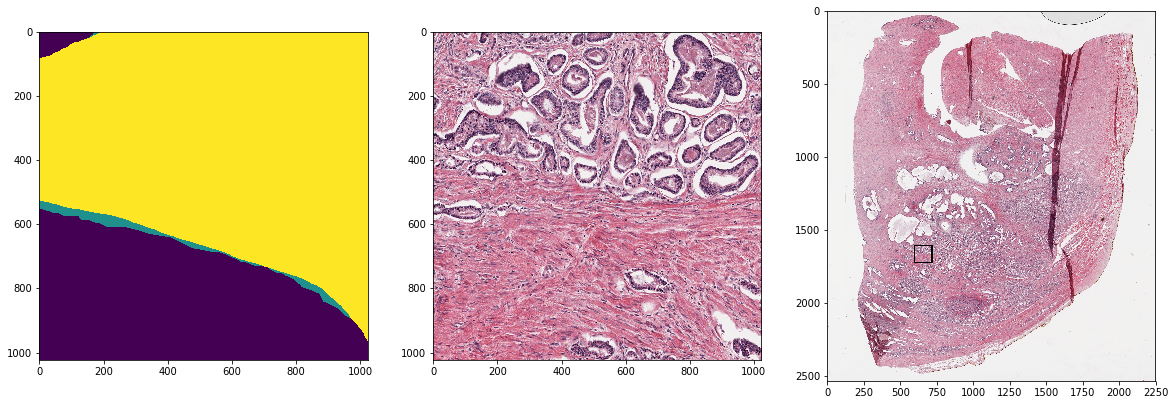

In [6]:
xml_fname=r'/mnt/data/home/pjl54/UPenn_prostate/20698.xml'
img_fname=r'/mnt/data/home/pjl54/UPenn_prostate/20698.svs'
desired_mpp = 1
wh = (1024,1024)

fig, ax = plt.subplots(1,3,figsize=(20,20))

x = np.random.randint(1000, high=17000, size=None, dtype='l')
y = np.random.randint(25000, high=26000, size=None, dtype='l')
x=9512
y=25596
start = time.time()
mask = mask_out_region(xml_fname,img_fname,desired_mpp,coords=(x,y),wh=wh)
end = time.time()
mask[0][0]=0
mask[0][1]=1
mask[0][2]=2
mask[0][3]=3
mask[0][4]=4

tile = gt.get_tile(img_fname,desired_mpp,coords=(x,y),wh=wh)
wsi = gt.show_tile_location(img_fname,desired_mpp,coords=(x,y),wh=wh)

ax[0].imshow(mask)
ax[1].imshow(tile)
ax[2].imshow(wsi)
print(end - start)